In [1]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [2]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


In [3]:
df = pd.read_csv('amazon_landing_page.csv')
df.head()

,user_id,group,landing_page,converted
0,851104,control,old_page,0
1,804228,control,old_page,0
2,661590,treatment,new_page,0
3,853541,treatment,new_page,0
4,864975,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   group         294480 non-null  object
 2   landing_page  294480 non-null  object
 3   converted     294480 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB


# EDA

In [5]:
# 1. Descriptive Statistics and Data Quality Check

# Generate descriptive statistics for the dataset
desc_stats = df.describe()
print(desc_stats)

# Check missing values and duplicated rows
print(f"\nMissing values in each column:\n {df.isnull().sum()}")
print(f"\nNumber of duplicate entries: {df.duplicated().sum()}")

             user_id      converted
count  294480.000000  294480.000000
mean   787973.538896       0.119658
std     91210.917091       0.324562
min    630000.000000       0.000000
25%    709031.750000       0.000000
50%    787932.500000       0.000000
75%    866911.250000       0.000000
max    945999.000000       1.000000

Missing values in each column:
 user_id         0
group           0
landing_page    0
converted       0
dtype: int64

Number of duplicate entries: 2


In [6]:
df.isnull().sum()

user_id         0
group           0
landing_page    0
converted       0
dtype: int64

In [7]:
# Checking consistency between 'group' and 'landing_page'
# This verifies if all entries where 'group' is 'control' have 'landing_page' set to 'old_page'
consistency_check = (df['group'] == 'control') == (df['landing_page'] == 'old_page')
print(f"\nConsistency between group and landing_page:  {consistency_check.all()}")


Consistency between group and landing_page:  False


In [8]:
# 2. Group Analysis
# Calculate the average conversion rate for each group
group_conversion = df.groupby('group')['converted'].mean()
print("\nConversion rate by group:\n", group_conversion)


Conversion rate by group:
 group
control      0.120399
treatment    0.118918
Name: converted, dtype: float64


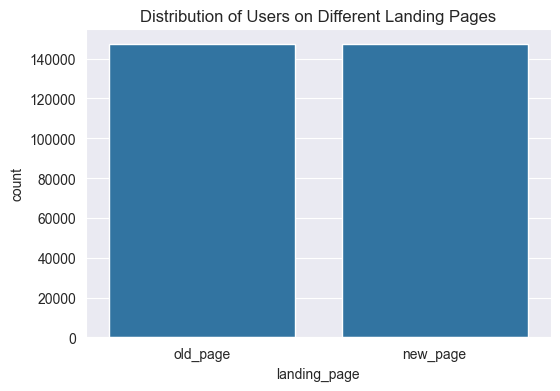

In [9]:
# Plot the count of users for each landing page to visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='landing_page', data=df)
plt.title('Distribution of Users on Different Landing Pages')
plt.show()

# Data Preprocessing

In [10]:
df_unique = df.drop_duplicates(subset=['user_id'])

In [11]:
# Checking for inconsistencies between group and landing_page

# Identify entries where the 'group' and 'landing_page' values do not match the expected assignment
# 'control' group should have 'old_page' and 'treatment' group should have 'new_page'
inconsistencies = df_unique[((df_unique['group'] == 'control') & (df_unique['landing_page'] != 'old_page')) |
                             ((df_unique['group'] == 'treatment') & (df_unique['landing_page'] != 'new_page'))]

# Counting the number of inconsistencies
num_inconsistencies = inconsistencies.shape[0]
print(f"Number of inconsistencies: {num_inconsistencies}")

Number of inconsistencies: 2044


In [12]:
# Option 1: Remove the inconsistent rows
df_fixed = df_unique.drop(inconsistencies.index)

# Bayesian A/B Testing

In [18]:
from scipy.stats import beta

# --- Count conversions and totals per group ---
conversions_A = df_fixed[(df_fixed['group'] == 'control') & (df_fixed['converted'] == 1)].shape[0]
conversions_B = df_fixed[(df_fixed['group'] == 'treatment') & (df_fixed['converted'] == 1)].shape[0]

total_A = df_fixed[df_fixed['group'] == 'control'].shape[0]
total_B = df_fixed[df_fixed['group'] == 'treatment'].shape[0]

# --- Prior parameters ---
alpha_prior = 1
beta_prior = 10  # prior belief: low conversion rates

# --- Posterior distributions (Beta) ---
posterior_A = beta(a=conversions_A + alpha_prior,
                   b=total_A - conversions_A + beta_prior)

posterior_B = beta(a=conversions_B + alpha_prior,
                   b=total_B - conversions_B + beta_prior)

# --- Draw samples from the posterior distributions ---
num_samples = 10000  # more samples for smoother estimate
samples_A = posterior_A.rvs(size=num_samples)
samples_B = posterior_B.rvs(size=num_samples)

# --- Probability that B is better than A ---
prob_B_better_than_A = np.mean(samples_B > samples_A)

print(f"Conversions A: {conversions_A}/{total_A}")
print(f"Conversions B: {conversions_B}/{total_B}")
print(f"Estimated probability that B > A: {prob_B_better_than_A:.4f}")



Conversions A: 17349/144226
Conversions B: 17134/144315
Estimated probability that B > A: 0.1012


### Proportions test with ChatGPT

**Null Hypothesis**: There is no difference between both groups

**Alternative Hypothesis**: There is a difference in both groups

In [21]:
# Proportions Test
import statsmodels.stats.proportion as proportion

# Perform a two-sample z-test for proportions
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative="two-sided")

# Interpret the p-value from the test to determine statistical significance
interpret_p_value(p_value, threshold=0.05)

p-value (0.19534709281210638) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


In [22]:
# Proportions Test
import statsmodels.stats.proportion as proportion

# Perform a one-sided z-test for proportions
# Testing if the proportion in group B is significantly larger than in group A
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative="larger")

# Interpret the p-value from the test to determine if B's conversion rate is significantly larger than A's
interpret_p_value(p_value, threshold=0.05)


p-value (0.09767354640605319) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


# Sequential Testing and Early Stopping

In [23]:
# Simulate Experiments
n_experiments = 1000  # Number of experiments to simulate
n_weeks = 5  # Duration of each experiment in weeks
n_per_week = 500  # Number of participants per week in each experiment

# Conversion rates for the control and treatment groups
cr_control = 0.12  # Conversion rate for the control group
cr_treatment = 0.11  # Conversion rate for the treatment group

In [24]:
# Running the simulations
early_stopping_results = []  # List to store results of early stopping

# Simulate for each experiment
for _ in range(n_experiments):
  # Simulate conversion data for the control group and treatment group
  control_group = np.random.binomial(1, cr_control, n_per_week * n_weeks)
  treatment_group = np.random.binomial(1, cr_treatment, n_per_week * n_weeks)

  # Sequentially analyze each week
  for week in range(1, n_weeks + 1):
    # Slice the data up to the current week
    control_data = control_group[:week * n_per_week]
    treatment_data = treatment_group[:week * n_per_week]

    # Prepare data for proportions test and perform the test
    z_value, p_value = proportion.proportions_ztest(
        [control_data.sum(), treatment_data.sum()],
        [len(control_data), len(treatment_data)])

    # Check if the p-value is below the significance level (0.05)
    if p_value < 0.05:
      early_stopping_results.append((week, p_value))  # Record week and p-value if significant
      break  # Stop the simulation for this experiment if result is significant
  else:
    # If no significant result was found, record the results at the end of the experiment
    early_stopping_results.append((n_weeks, p_value))


In [25]:
# Check the results
early_stopping_results

[(4, np.float64(0.009716096656288812)),
 (5, np.float64(0.6881190168273292)),
 (5, np.float64(0.18454704643899267)),
 (4, np.float64(0.002942093070459276)),
 (5, np.float64(0.7277235466695506)),
 (3, np.float64(0.0019268762624503187)),
 (5, np.float64(0.7604762562752491)),
 (5, np.float64(0.4440721143398194)),
 (5, np.float64(0.48623432138829725)),
 (5, np.float64(0.8637225511075268)),
 (5, np.float64(0.48933577586749444)),
 (5, np.float64(0.3489535337714157)),
 (5, np.float64(0.3246133249622758)),
 (2, np.float64(0.0054090791994714105)),
 (5, np.float64(0.8587275784914961)),
 (1, np.float64(0.005691416547658762)),
 (5, np.float64(0.5177689159364942)),
 (5, np.float64(0.08663547141532087)),
 (5, np.float64(0.02763021993172674)),
 (5, np.float64(0.11132610765859739)),
 (5, np.float64(0.07686405547333731)),
 (5, np.float64(0.10862525518524692)),
 (1, np.float64(0.037378381700061344)),
 (5, np.float64(0.5571281300018014)),
 (5, np.float64(0.48872122780024974)),
 (5, np.float64(0.929930228

In [26]:
# Analyze the results

# Unpack the weeks and p-values from the early stopping results
stopped_weeks, stopped_p_values = zip(*early_stopping_results)

# Calculate the average week at which early stopping occurred
average_stopping_week = np.mean(stopped_weeks)

# Print the average stopping week across all simulations
print(f"The Average Stopping week is {average_stopping_week}")


The Average Stopping week is 4.239
